# AirMSPI Dynamic Radiance data loading

This notebook demonstrates how to load data from AirMSPI's files. 

A pre-processing is applied on the data for the cloud reconstruction optimization.

---


The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import copy
import numpy as np
import shdom
import glob

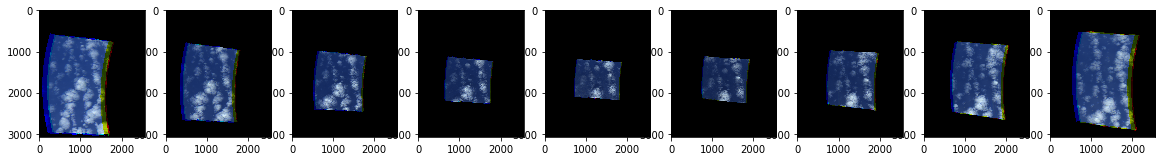

In [2]:
# Set data directory
data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W'
# data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_202514Z_NorthPacificOcean-32N123W'
# data_dir = '../AirMSPI/21views'
# data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20160826_104727Z_SouthAtlanticOcean-14S19W'


format_ = '*.hdf'  # load
paths = sorted(glob.glob(data_dir + '/' + format_))
n_files = len(paths)
# Show AirMSPI images in data directory
shdom.AirMSPIDynamicMeasurements().imshow(data_dir)

In [3]:
# Crop cloud from images, uses OpenCV package may be problematic in some versions
roi = []
i=0

In [4]:
# %matplotlib notebook 
# for i in range(i,n_files):
    # roi.append(shdom.AirMSPIMeasurements().select_region_of_interest(data_dir,i))

In [5]:
print(roi)

[]


In [6]:
# roi = [[1500, 2000, 800, 1250], [1600, 2050, 850, 1300], [1600, 2100, 800, 1300], [1800, 2200, 800, 1400], [1900, 2200, 1000, 1400],  [1900, 2200, 1100, 1600], [1900, 2300, 1100, 1500],[2000, 2500, 1100, 1600],[2000, 2500, 1100, 1600]]
roi = [[1288, 1608, 588, 835], [1356, 1680, 640, 892], [1416, 1756, 696, 940], [1480, 1820, 732, 992], [1540, 1884, 792, 1036], [1604, 1944, 828, 1085], [1660, 2012, 884, 1140], [1728, 2084, 936, 1190], [1792, 2152, 980, 1255]]

# pre-calculate region of interest for demonstration for 
# AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W data
# roi = [[1288, 1608, 588, 835], [1356, 1680, 640, 892], [1416, 1756, 696, 940], [1480, 1820, 732, 992], [1540, 1884, 792, 1036], [1604, 1944, 828, 1085], [1660, 2012, 884, 1140], [1728, 2084, 936, 1190], [1792, 2152, 980, 1255]]
import scipy.io as sio
# roi_21 = sio.loadmat('../AirMSPI/21views/roi21_smallcloud.mat')
# roi_21 = roi_21['roi21']
# roi= sio.loadmat('../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20160826_104727Z_SouthAtlanticOcean-14S19W/roi.mat')
# roi = roi['roi']
# roi_21 = roi_21[0:8].tolist()+roi_21[13:].tolist()
# roi_21 = roi_21[[0,1,2,3]].tolist()

In [7]:
%matplotlib inline

# roi = np.round(roi_21).astype(np.int)
valid_wavelength = [660]
airmspi_measurements = shdom.AirMSPIDynamicMeasurements()
airmspi_measurements.load_from_hdf(data_dir,region_of_interest=roi,valid_wavelength=valid_wavelength)

In [8]:
# airmspi_measurements.calc_cloud_base_height(3,[1388, 1802],[1376, 1718])

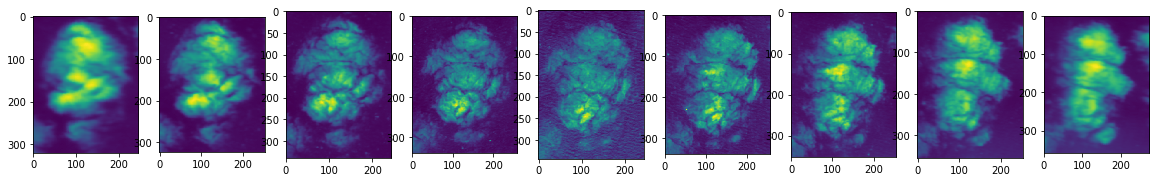

In [9]:
# View images
from skimage import filters

%matplotlib inline
f, axarr = plt.subplots(1, len(airmspi_measurements.images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image in zip(axarr,  copy.deepcopy(airmspi_measurements.images)):
    if len(image.shape)>2 and image.shape[2]==2:
        image = np.concatenate((image,np.reshape(image[:,:,0],(image.shape[0],image.shape[1],1))*0),2)
    elif len(image.shape)>2 and image.shape[2]>3:
        image = image[:,:,0:2]
    # thr = filters.threshold_isodata(image)
    # im = copy.deepcopy(image)
    # im = im >thr
    ax.imshow(image)
    # ax.imshow(im)

In [10]:
# plt.imshow(airmspi_measurements.images[20])


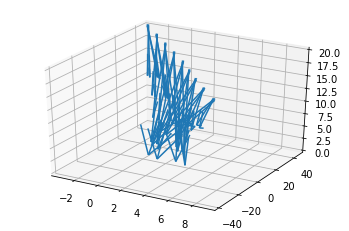

In [11]:
# Plot locations of the cameras

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init()
x_min = airmspi_measurements._projections.x.min()
x_max = airmspi_measurements._projections.x.max()
y_min = airmspi_measurements._projections.y.min()
y_max = airmspi_measurements._projections.y.max()
airmspi_measurements.plot(ax,[x_min, x_max],[y_min, y_max],[0, 20],20)

In [12]:
# Test cloud's pre-processing alignment by space carve object  
nx = 60
ny = 60
nz = 20
images = airmspi_measurements.images.copy()

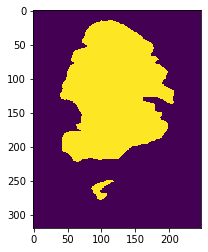

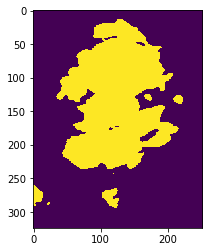

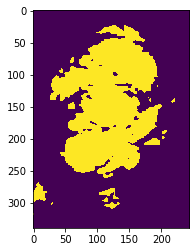

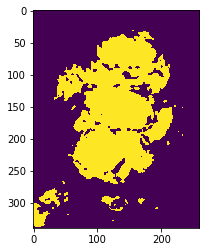

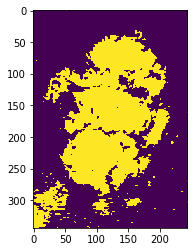

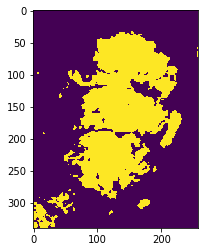

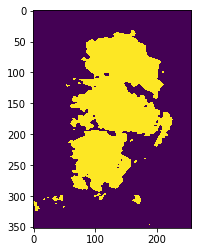

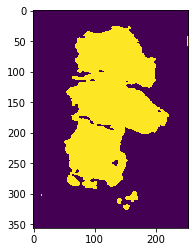

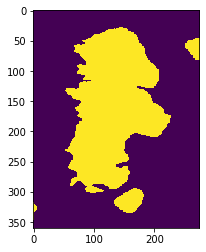

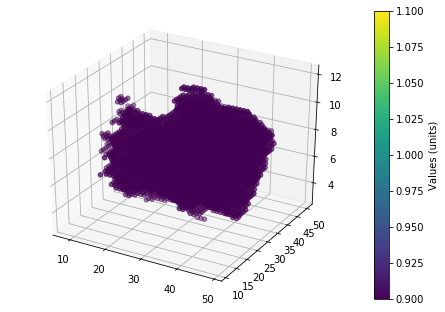

4683
[0.0, 0.0, 0]
0.7927666700383246


In [13]:
from scipy.ndimage import center_of_mass
# i=0
# for im in images:
#     # com = (center_of_mass(im))
#     # im = cv2.Canny((im/0.02*255).astype(np.uint8),90,100)
#     # im = im *0
#     # im[50:51,50:51] = 1
#     # im[int(com[0]),int(com[1])] = 1
#     airmspi_measurements.images[i] = im
#     i+=1
grid = shdom.Grid(bounding_box=airmspi_measurements.bb,nx=nx,ny=ny,nz=nz)
# grid = shdom.Grid(bounding_box=shdom.BoundingBox(x_min,y_min,0.0,x_max,y_max,20),nx=nx,ny=ny,nz=nz)
carver = shdom.DynamicSpaceCarver(airmspi_measurements)
mask_list, best_dynamic_grid, cloud_velocity = carver.carve(grid, agreement=0.9,
                                                            thresholds=-0.02,time_list=airmspi_measurements.time_list, vx_max=0,vy_max=0,verbose=1)
shdom.cloud_plot(mask_list[0].data)
print(sum(sum(sum(mask_list[0].data))))
print(cloud_velocity)
center_of_mass = center_of_mass(mask_list[0].data)
print(center_of_mass[2]/(nz-1)*(grid.zmax)+grid.zmin)

In [14]:
# plt.imshow(mask_list[0].data[:,:,25])

In [15]:
# %matplotlib inline
# 
# im = np.zeros((400,400,9))
# for i,(image, projection) in enumerate(zip(airmspi_measurements.images, airmspi_measurements._projections.projection_list)):
#     x_r = np.reshape(np.rint(projection.x*100),image.shape,order='F')
#     y_r = np.reshape(np.rint(projection.y*100),image.shape,order='F')
#     im[y_r.astype(int),x_r.astype(int),i] += image
# plt.imshow(im[:,:,[0,4,8]]*50)
# plt.show()

In [16]:
# img1 = images[0][:, :, np.newaxis] 
# img1 = (img1/0.02*255).astype(np.uint8)# queryImage
# img2 = images[1][:, :, np.newaxis]  # trainImage
# img2 = (img2/0.02*255).astype(np.uint8)# queryImage
# new_images=[np.zeros(im.shape) for im in images]
# # Initiate SIFT detector
# sift = cv2.xfeatures2d.SIFT_create()
# 
# # find the keypoints and descriptors with SIFT
# kp=[]
# des=[]
# # Initialize lists
# list_kp1 = []
# list_kp2 = []
# ims=[]
# i=0
# for im1, im2 in zip(images[:-1],images[1:]): 
#     im1 = im1[:, :, np.newaxis] 
#     im1 = (im1/im1.max()*255).astype(np.uint8)
#     im2 = im2[:, :, np.newaxis] 
#     im2 = (im2/im2.max()*255).astype(np.uint8)
#     kp1, des1 = sift.detectAndCompute(im1,None)
#     kp2, des2 = sift.detectAndCompute(im2,None)
# 
#     # BFMatcher with default params
#     bf = cv2.BFMatcher()
#     matches=(bf.knnMatch(des1,des2, k=2))
# 
# # Apply ratio test
#     good = []
#     for m,n in matches:
#         if m.distance < 0.4*n.distance:
#             good.append([m])
# 
#     img_match = np.empty((max(im1.shape[0], im2.shape[0]), im1.shape[1] + img2.shape[1], 1), dtype=np.uint8)
# # cv2.drawMatchesKnn expects list of lists as matches.
#     img3 = cv2.drawMatchesKnn(im1,kp1,im2,kp2,good,outImg=img_match,flags=2)
#     plt.imshow(img3),plt.show()    
#     # For each match...
#     for mat in good:
#     
#         # Get the matching keypoints for each of the images
#         img1_idx = mat[0].queryIdx
#         img2_idx = mat[0].trainIdx
#     
#         # x - columns
#         # y - rows
#         # Get the coordinates
#         (x1, y1) = kp1[img1_idx].pt
#         (x2, y2) = kp2[img2_idx].pt
#     
#         # Append to each list
#         new_images[i][np.int(y1), np.int(x1)] = 1
#         new_images[i+1][np.int(y2), np.int(x2)] = 1
#         
#         list_kp1.append((np.round(x1), np.round(y1)))
#         list_kp2.append((np.round(x2), np.round(y2)))
#     print(np.sum(new_images[i].ravel()))
#     i +=1

In [17]:
# # Test cloud's pre-processing alignment by space carve object  
# nx = 60
# ny = 600
# nz = 60
# from scipy.ndimage import center_of_mass
# airmspi_measurements._images=new_images
# plt.show()
# grid = shdom.Grid(bounding_box=airmspi_measurements.bb,nx=nx,ny=ny,nz=nz)
# grid = shdom.Grid(bounding_box=shdom.BoundingBox(x_min,y_min,0.0,x_max,y_max,5),nx=nx,ny=ny,nz=nz)
# carver = shdom.DynamicSpaceCarver(airmspi_measurements)
# mask_list, best_dynamic_grid, cloud_velocity = carver.carve(grid, agreement=0.1, thresholds=0.005,time_list=airmspi_measurements.time_list, vx_max=0,vy_max=0,verbose=False)
# shdom.cloud_plot(mask_list[0].data)
# print(sum(sum(sum(mask_list[0].data))))
# print(cloud_velocity)
# center_of_mass = center_of_mass(mask_list[0].data)
# print(center_of_mass[2]/(nz-1)*(grid.zmax)+grid.zmin)
# import scipy.io as sio

In [18]:
num_bins = 30
# the histogram of the data
# n, bins, patches = plt.hist(airmspi_measurements.images[0], num_bins, normed=1, facecolor='blue', alpha=0.5)

In [19]:
# mask = mask_list[0].data
# sio.savemat('mask.mat',{'mask':mask})

In [20]:
# Save AirMSPI measurments
if len(valid_wavelength) == 1:
    output_dir = 'experiments/AirMSPI/dynamic_medium/monochromatic'
else:
    output_dir = 'experiments/AirMSPI/dynamic_medium/polychromatic'
airmspi_measurements.save_airmspi_measurements(output_dir)




In [21]:
airmspi_dict = {}
airmspi_dict["resolution"] = airmspi_measurements.camera.dynamic_projection.resolution
sun_azimuth_mean = (np.sum(airmspi_measurements.sun_azimuth_list) % 360)/9
sun_zenith_mean = (np.sum(airmspi_measurements.sun_zenith_list))/9
airmspi_dict["sun_azimuth"] = sun_azimuth_mean
airmspi_dict["sun_zenith"] = sun_zenith_mean
airmspi_dict["cloud_mask"] = mask_list[0].data
airmspi_dict["x"] = airmspi_measurements.camera.dynamic_projection.x
airmspi_dict["y"] = airmspi_measurements.camera.dynamic_projection.y
airmspi_dict["z"] = airmspi_measurements.camera.dynamic_projection.z
airmspi_dict["zenith"] = airmspi_measurements.camera.dynamic_projection.zenith
airmspi_dict["azimuth"] = airmspi_measurements.camera.dynamic_projection.azimuth
airmspi_dict["images"] = airmspi_measurements.images
airmspi_dict["bbox"] = np.array([[grid.xmin, grid.xmax],
                                 [grid.ymin, grid.ymax],
                                 [grid.zmin, grid.zmax],
                                ])
airmspi_dict["grid_shape"] = grid.shape
import pickle
a_file = open("airmspi_data.pkl", "wb")
pickle.dump(airmspi_dict, a_file)
a_file.close()

a_file = open("airmspi_measurements.pkl", "wb")
pickle.dump(airmspi_measurements, a_file)
a_file.close()

In [22]:

print(sun_zenith_mean)
print(mask_list[0].data.shape)
print(grid.dx*nx)

132.69760155297737
(60, 60, 20)
3.710021674633026


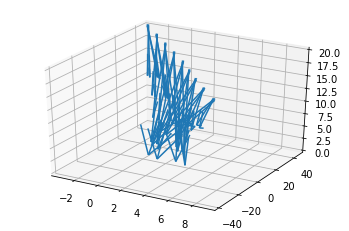

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init()
airmspi_measurements.plot(ax,[x_min, x_max],[y_min, y_max],[0, 20],20)

In [24]:
print(airmspi_measurements.camera.dynamic_projection.mu[:5])
print(np.cos((np.pi/180)*airmspi_measurements.camera.dynamic_projection.zenith[:5]))

[0.38288245 0.3828929  0.38289556 0.3829014  0.3829113 ]
[0.38288245 0.3828929  0.38289565 0.3829014  0.3829114 ]


In [25]:
print(airmspi_measurements.camera.dynamic_projection.phi[:5])
print((np.pi/180)*airmspi_measurements.camera.dynamic_projection.azimuth[:5])



[1.7151669 1.7149521 1.714736  1.7145205 1.7143055]
[1.7151668 1.714952  1.7147359 1.7145203 1.7143054]
